## Hybrid Attempt (v4)

>>> INIZIO PIPELINE OPZIONE B (Inflazione PCA + Tematico GT + Test Stazionarietà) <<<

--- Inizio Caricamento Dati ---
--- Fine Caricamento Dati (9 gruppi caricati) ---

--- Inizio Identificazione Periodo Comune ---
Info (Periodo Comune): Da 2004-01-01 a 2024-12-01
--- Fine Identificazione Periodo Comune ---

--- Inizio Combinazione Dati ---
Info (Combinazione): DF combinato 252r x 45c.
--- Fine Combinazione Dati ---

--- Inizio Pulizia Valori Google Trends ('<1') ---
--- Fine Pulizia Valori Google Trends --- 

--- Inizio Gestione NaN (Strategia: fillna) ---
Info: Nessun NaN trovato.
--- Inizio Standardizzazione Serie (Z-score) ---
--- Fine Standardizzazione Serie ---

--- Inizio Creazione Indice Inflazione PCA (keyword: 'inflazione') ---
Info: Indice Inflazione PCA creato da 9 termini. Var. Spiegata: 99.15%
--- Fine Creazione Indice Inflazione PCA ---

--- Inizio Creazione Indici PCA per Gruppo (Purificati) ---
Gruppo 'Termini_Diretti' (Purificato): Var: 42.61% (4 vars)
Gruppo 'Alimen

/var/folders/3m/15k2tqw90_s76rn9_8yw2p3r0000gn/T/ipykernel_17858/1167793934.py:246: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test_ct = kpss(timeseries_clean, regression='ct', nlags="auto")
/var/folders/3m/15k2tqw90_s76rn9_8yw2p3r0000gn/T/ipykernel_17858/1167793934.py:235: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test_c = kpss(timeseries_clean, regression='c', nlags="auto")
/var/folders/3m/15k2tqw90_s76rn9_8yw2p3r0000gn/T/ipykernel_17858/1167793934.py:246: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test_ct = kpss(timeseries_clean, regression='ct', nlags="auto")


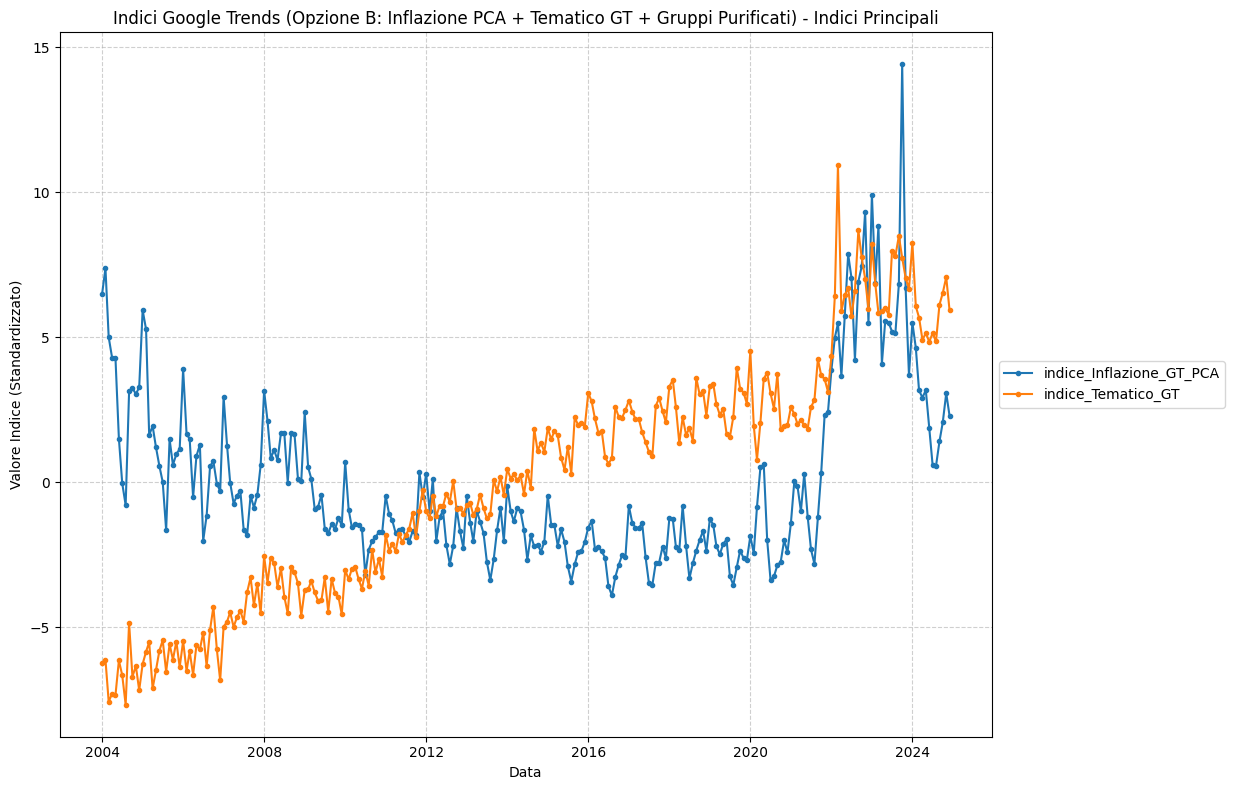

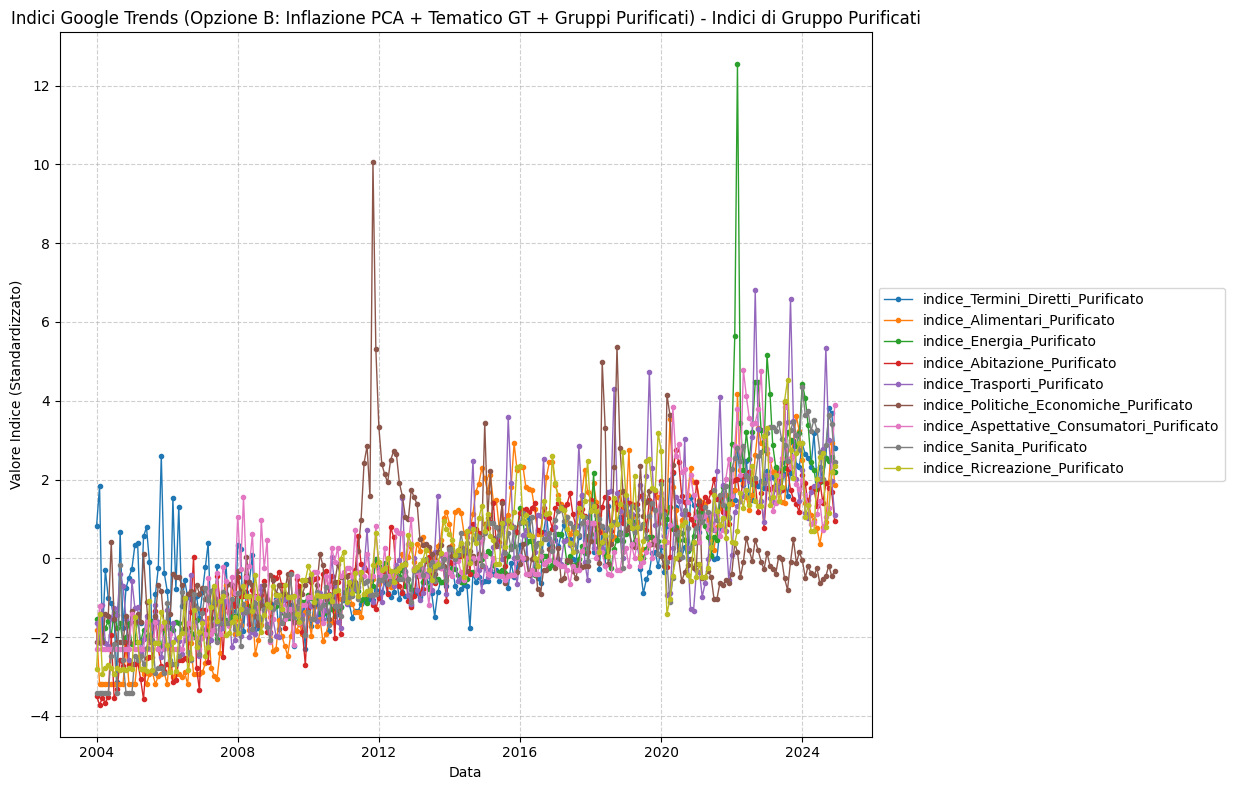

Info: Indici salvati in '/Users/tommaso/Desktop/tesi-inflation-gt/PCA/indici_gt_hybrid_v4_tests.csv'
--- Fine Visualizzazione e Salvataggio Indici ---


>>> PIPELINE OPZIONE B COMPLETATA <<<


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import adfuller, kpss # Test di stazionarietà
# import statsmodels.api as sm # Da decommentare se si vuole usare X-13

# --- CONFIGURAZIONE ---
PATH_DATI = "/Users/tommaso/Desktop/tesi-inflation-gt/Official_4" 
PATH_SALVATAGGIO_INDICI = '/Users/tommaso/Desktop/tesi-inflation-gt/PCA/indici_gt_hybrid_v4_tests.csv'

NOMI_GRUPPI_DICT = {
    "Gruppo1(4)": "Termini_Diretti",
    "Gruppo2(4)": "Alimentari",
    "Gruppo3(4)": "Energia",
    "Gruppo4(4)": "Abitazione",
    "Gruppo5(4)": "Trasporti",
    "Gruppo6(4)": "Politiche_Economiche",
    "Gruppo7(4)": "Aspettative_Consumatori",
    "Gruppo8(4)": "Sanita",
    "Gruppo9(4)": "Ricreazione",
}
# Parola chiave per identificare le colonne relative all'inflazione diretta
INFLATION_KEYWORD_IN_COLNAME = "inflazione"
# Livelli di significatività per i test di stazionarietà
SIGNIFICANCE_LEVEL = 0.05

# --- 1. CARICAMENTO DATI ---
def carica_dati_gt(path_csv, nomi_file_mappati):
    dati_caricati_per_gruppo = {}
    print("--- Inizio Caricamento Dati ---")
    for nome_file_csv, nome_gruppo_logico in nomi_file_mappati.items():
        file_path = os.path.join(path_csv, f"{nome_file_csv}.csv")
        try:
            df = pd.read_csv(file_path, skiprows=2, header=0)
            df.columns = [str(col).strip().lower() for col in df.columns]
            colonna_data = None
            for possible_date_col in ['mese', 'month', 'settimana', 'week', 'giorno', 'day']:
                if possible_date_col in df.columns:
                    colonna_data = possible_date_col
                    break
            if colonna_data is None: raise ValueError(f"Nessuna colonna data standard trovata in {nome_file_csv}")
            if colonna_data != 'mese': print(f"Info: Trovata colonna data '{colonna_data}' in {nome_file_csv}.")
            df.set_index(colonna_data, inplace=True)
            try: df.index = pd.to_datetime(df.index)
            except Exception: df.index = pd.to_datetime(df.index, format="%Y-%m")
            dati_caricati_per_gruppo[nome_gruppo_logico] = df
        except Exception as e: print(f"ERRORE nel caricamento di '{nome_file_csv}.csv': {e}")
    print(f"--- Fine Caricamento Dati ({len(dati_caricati_per_gruppo)} gruppi caricati) ---\n")
    return dati_caricati_per_gruppo

# --- 2. IDENTIFICAZIONE PERIODO COMUNE ---
def trova_periodo_comune(dati_dict_input):
    print("--- Inizio Identificazione Periodo Comune ---")
    if not dati_dict_input: return None, None
    date_inizio_valide, date_fine_valide = [], []
    for df in dati_dict_input.values():
        if not df.empty and isinstance(df.index, pd.DatetimeIndex):
            date_inizio_valide.append(df.index.min()); date_fine_valide.append(df.index.max())
    if not date_inizio_valide: return None, None
    inizio_comune_calc, fine_comune_calc = max(date_inizio_valide), min(date_fine_valide)
    if inizio_comune_calc > fine_comune_calc: print(f"Attenzione: Nessun periodo comune valido."); return None, None
    print(f"Info (Periodo Comune): Da {inizio_comune_calc.strftime('%Y-%m-%d')} a {fine_comune_calc.strftime('%Y-%m-%d')}")
    print("--- Fine Identificazione Periodo Comune ---\n")
    return inizio_comune_calc, fine_comune_calc

# --- 3. COMBINAZIONE DATI SU PERIODO COMUNE ---
def combina_dati_su_periodo_comune(dati_dict_input, inizio_dt, fine_dt):
    print("--- Inizio Combinazione Dati ---")
    if inizio_dt is None or fine_dt is None or not dati_dict_input: return None
    idx_comune = pd.date_range(start=inizio_dt, end=fine_dt, freq='MS')
    df_combinato_finale = pd.DataFrame(index=idx_comune)
    for nome_gruppo_logico, df_originale in dati_dict_input.items():
        if df_originale.empty or not isinstance(df_originale.index, pd.DatetimeIndex): continue
        df_periodo_gruppo = df_originale[(df_originale.index >= inizio_dt) & (df_originale.index <= fine_dt)]
        if df_periodo_gruppo.empty: continue
        for col_originale_nome in df_periodo_gruppo.columns:
            nome_colonna_con_prefisso = f"{nome_gruppo_logico}_{col_originale_nome}"
            df_combinato_finale[nome_colonna_con_prefisso] = df_periodo_gruppo[col_originale_nome].reindex(df_combinato_finale.index)
    print(f"Info (Combinazione): DF combinato {df_combinato_finale.shape[0]}r x {df_combinato_finale.shape[1]}c.")
    print("--- Fine Combinazione Dati ---\n")
    return df_combinato_finale

# --- 4. PULIZIA VALORI GOOGLE TRENDS ('<1') ---
def pulisci_valori_gt(df_input):
    print("--- Inizio Pulizia Valori Google Trends ('<1') ---")
    if df_input is None: return None
    df_pulito = df_input.copy()
    for col in df_pulito.columns:
        col_as_str = df_pulito[col].astype(str)
        if col_as_str.str.contains(r'< ?1').any():
            df_pulito[col] = df_pulito[col].replace(to_replace=r'< ?1', value=0.5, regex=True)
        df_pulito[col] = pd.to_numeric(df_pulito[col], errors='coerce')
    print("--- Fine Pulizia Valori Google Trends --- \n")
    return df_pulito

# --- 5. GESTIONE VALORI MANCANTI (NaN) ---
def gestisci_nan(df_input, strategy='fillna', fill_value=0, interpolate_method='linear'):
    print(f"--- Inizio Gestione NaN (Strategia: {strategy}) ---")
    if df_input is None: return None
    df_gestito = df_input.copy()
    if not df_gestito.isnull().values.any(): print("Info: Nessun NaN trovato."); return df_gestito
    if strategy == 'fillna': df_gestito = df_gestito.fillna(fill_value)
    elif strategy == 'interpolate':
        df_gestito = df_gestito.interpolate(method=interpolate_method, axis=0)
        if df_gestito.isnull().values.any(): df_gestito = df_gestito.fillna(fill_value)
    print("Info: NaN gestiti.")
    print("--- Fine Gestione NaN ---\n")
    return df_gestito

# --- 6. STANDARDIZZAZIONE SERIE (Z-SCORE) ---
def standardizza_serie_temporali(df_input):
    print("--- Inizio Standardizzazione Serie (Z-score) ---")
    if df_input is None: return None
    df_std = df_input.copy()
    for col in df_std.columns:
        if not pd.api.types.is_numeric_dtype(df_std[col]): continue
        media, std_dev = df_std[col].mean(), df_std[col].std()
        df_std[col] = (df_std[col] - media) / std_dev if std_dev > 1e-9 else 0
    print("--- Fine Standardizzazione Serie ---\n")
    return df_std

# --- 7. CREAZIONE INDICE INFLAZIONE TRAMITE PCA E SEPARAZIONE TERMINI ---
def crea_indice_inflazione_pca_e_separa_termini(df_std_input, inflation_keyword):
    print(f"--- Inizio Creazione Indice Inflazione PCA (keyword: '{inflation_keyword}') ---")
    if df_std_input is None or df_std_input.empty: return pd.Series(dtype=float), df_std_input
    colonne_inflazione = [col for col in df_std_input.columns if inflation_keyword.lower() in col.lower()]
    indice_inflazione_pca_series = pd.Series(index=df_std_input.index, dtype=float)
    df_senza_termini_inflazione = df_std_input.copy()
    if not colonne_inflazione: print(f"Attenzione: Nessun termine '{inflation_keyword}' trovato.")
    else:
        df_termini_inflazione_validi = df_std_input[colonne_inflazione].loc[:, df_std_input[colonne_inflazione].var(skipna=True) > 1e-9]
        if df_termini_inflazione_validi.empty: print(f"Attenzione: Nessun termine '{inflation_keyword}' con varianza sufficiente.")
        elif df_termini_inflazione_validi.shape[1] == 1:
            indice_inflazione_pca_series = df_termini_inflazione_validi.iloc[:, 0]
            print(f"Info: Usata singola colonna valida per Indice Inflazione: {df_termini_inflazione_validi.columns[0]}")
        else:
            pca_infl = PCA(n_components=1)
            try:
                if df_termini_inflazione_validi.isnull().values.any(): raise ValueError("NaN in PCA data for inflation index.")
                componente_infl = pca_infl.fit_transform(df_termini_inflazione_validi)
                indice_inflazione_pca_series = pd.Series(componente_infl.flatten(), index=df_termini_inflazione_validi.index)
                print(f"Info: Indice Inflazione PCA creato da {df_termini_inflazione_validi.shape[1]} termini. Var. Spiegata: {pca_infl.explained_variance_ratio_[0]:.2%}")
            except Exception as e: print(f"ERRORE PCA Indice Inflazione: {e}")
        df_senza_termini_inflazione = df_std_input.drop(columns=colonne_inflazione, errors='ignore')
    print("--- Fine Creazione Indice Inflazione PCA ---\n")
    return indice_inflazione_pca_series, df_senza_termini_inflazione

# --- 8. CREAZIONE INDICI PCA PER GRUPPO (PURIFICATI) ---
def crea_indici_pca_per_gruppo_purificati(df_input_senza_infl, nomi_gruppi_mappati):
    print("--- Inizio Creazione Indici PCA per Gruppo (Purificati) ---")
    if df_input_senza_infl is None or df_input_senza_infl.empty: return pd.DataFrame(index=df_input_senza_infl.index if df_input_senza_infl is not None else None)
    indici_pca_df = pd.DataFrame(index=df_input_senza_infl.index)
    for nome_gruppo_logico in nomi_gruppi_mappati.values():
        colonne_del_gruppo = [col for col in df_input_senza_infl.columns if col.startswith(f"{nome_gruppo_logico}_")]
        nome_indice = f'indice_{nome_gruppo_logico}_Purificato' # Nome standard per l'indice di gruppo
        if not colonne_del_gruppo: indici_pca_df[nome_indice] = np.nan; continue
        dati_gruppo_pca_validi = df_input_senza_infl[colonne_del_gruppo].loc[:, df_input_senza_infl[colonne_del_gruppo].var(skipna=True) > 1e-9]
        if dati_gruppo_pca_validi.shape[1] >= 1:
            if dati_gruppo_pca_validi.shape[1] == 1:
                indici_pca_df[nome_indice] = dati_gruppo_pca_validi.iloc[:, 0]
            else:
                pca = PCA(n_components=1)
                try:
                    if dati_gruppo_pca_validi.isnull().values.any(): raise ValueError("NaN in group PCA data.")
                    componente = pca.fit_transform(dati_gruppo_pca_validi)
                    indici_pca_df[nome_indice] = componente.flatten()
                    print(f"Gruppo '{nome_gruppo_logico}' (Purificato): Var: {pca.explained_variance_ratio_[0]:.2%} ({dati_gruppo_pca_validi.shape[1]} vars)")
                except Exception as e: print(f"ERRORE PCA grp '{nome_gruppo_logico}': {e}"); indici_pca_df[nome_indice] = np.nan
        else: indici_pca_df[nome_indice] = np.nan
    print("--- Fine Creazione Indici PCA per Gruppo (Purificati) ---\n")
    return indici_pca_df

# --- 9. CREAZIONE INDICE TEMATICO GT (PCA SU INDICI DI GRUPPO PURIFICATI) ---
def crea_indice_tematico_gt(df_indici_gruppo_puri_input):
    print("--- Inizio Creazione Indice Tematico GT ---")
    nome_indice_output = 'indice_Tematico_GT'
    if df_indici_gruppo_puri_input is None or df_indici_gruppo_puri_input.empty:
        return pd.Series(dtype=float, index=df_indici_gruppo_puri_input.index if df_indici_gruppo_puri_input is not None else None)
    df_per_pca_tematica = df_indici_gruppo_puri_input.dropna(axis=0, how='any')
    serie_indice_tematico_gt = pd.Series(index=df_indici_gruppo_puri_input.index, dtype=float)
    if df_per_pca_tematica.empty: print("Attenzione: Nessuna riga dopo rimozione NaN. Indice Tematico non creato."); return serie_indice_tematico_gt
    indici_tematici_validi = df_per_pca_tematica.loc[:, df_per_pca_tematica.var(skipna=True) > 1e-9]
    if indici_tematici_validi.shape[1] >= 1:
        if indici_tematici_validi.shape[1] == 1:
            print(f"Info: Un solo indice di gruppo purificato valido ('{indici_tematici_validi.columns[0]}'). Usato come Indice Tematico GT.")
            serie_indice_tematico_gt = indici_tematici_validi.iloc[:,0].reindex(df_indici_gruppo_puri_input.index)
        else:
            pca_tematico = PCA(n_components=1)
            try:
                componente_tematico = pca_tematico.fit_transform(indici_tematici_validi)
                temp_serie = pd.Series(componente_tematico.flatten(), index=indici_tematici_validi.index)
                serie_indice_tematico_gt = temp_serie.reindex(df_indici_gruppo_puri_input.index)
                print(f"\n{nome_indice_output}: Var. Spiegata: {pca_tematico.explained_variance_ratio_[0]:.2%} (su {indici_tematici_validi.shape[1]} indici purificati)")
                print(f"  Loadings su {nome_indice_output}:"); [print(f"    {n}: {l:.4f}") for n,l in zip(indici_tematici_validi.columns, pca_tematico.components_[0])]
            except Exception as e: print(f"ERRORE PCA Indice Tematico: {e}")
    else: print("Info: Nessun indice di gruppo purificato con varianza sufficiente per Indice Tematico GT.")
    print("--- Fine Creazione Indice Tematico GT ---\n")
    return serie_indice_tematico_gt

# --- 10. TEST DI STAZIONARIETÀ (ADF E KPSS) ---
def test_stazionarieta(timeseries, series_name="Serie", significance_level=0.05):
    """
    Esegue i test ADF e KPSS su una serie temporale e stampa i risultati.
    """
    print(f"--- Test di Stazionarietà per: {series_name} ---")
    timeseries_clean = timeseries.dropna() # Rimuovo NaN solo per i test

    if timeseries_clean.empty:
        print("Serie vuota dopo rimozione NaN. Impossibile testare.")
        return

    # Test ADF (Augmented Dickey-Fuller)
    # Ipotesi Nulla (H0): La serie ha una radice unitaria (non è stazionaria).
    # Ipotesi Alternativa (H1): La serie non ha una radice unitaria (è stazionaria).
    # Se p-value < significance_level => Rifiuto H0 => Stazionaria
    print("-> Test ADF:")
    adf_test = adfuller(timeseries_clean, autolag='AIC')
    adf_output = pd.Series(adf_test[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in adf_test[4].items():
        adf_output['Critical Value (%s)'%key] = value
    print(adf_output)
    if adf_test[1] <= significance_level:
        print(f"Risultato ADF: La serie '{series_name}' è probabilmente STAZIONARIA (p-value={adf_test[1]:.3f} <= {significance_level}).")
    else:
        print(f"Risultato ADF: La serie '{series_name}' è probabilmente NON STAZIONARIA (p-value={adf_test[1]:.3f} > {significance_level}).")

    print("\n-> Test KPSS (Kwiatkowski-Phillips-Schmidt-Shin):")
    # Ipotesi Nulla (H0): La serie è stazionaria attorno a una media o a un trend deterministico.
    # Ipotesi Alternativa (H1): La serie ha una radice unitaria (non è stazionaria).
    # Se statistica test > valore critico => Rifiuto H0 => Non Stazionaria (intorno a quel livello/trend)
    # Se p-value < significance_level => Rifiuto H0 => Non Stazionaria (interpretazione comune del p-value, anche se per KPSS è un po' diverso)
    # Testo per stazionarietà attorno a una costante ('c')
    kpss_test_c = kpss(timeseries_clean, regression='c', nlags="auto")
    kpss_output_c = pd.Series(kpss_test_c[0:3], index=['Test Statistic','p-value','Lags Used'])
    # Nota: il p-value di KPSS ha limiti (es. > 0.1 o < 0.01). Interpretare con cautela.
    print("KPSS (regression='c' - Stazionarietà attorno a costante):")
    print(kpss_output_c)
    if kpss_test_c[1] >= significance_level:
         print(f"Risultato KPSS ('c'): NON si rifiuta H0. La serie '{series_name}' è probabilmente STAZIONARIA attorno a una costante (p-value={kpss_test_c[1]:.3f} >= {significance_level}).")
    else:
         print(f"Risultato KPSS ('c'): Si rifiuta H0. La serie '{series_name}' è probabilmente NON STAZIONARIA attorno a una costante (p-value={kpss_test_c[1]:.3f} < {significance_level}).")

    # Testo anche per stazionarietà attorno a un trend ('ct')
    kpss_test_ct = kpss(timeseries_clean, regression='ct', nlags="auto")
    kpss_output_ct = pd.Series(kpss_test_ct[0:3], index=['Test Statistic','p-value','Lags Used'])
    print("\nKPSS (regression='ct' - Stazionarietà attorno a trend):")
    print(kpss_output_ct)
    if kpss_test_ct[1] >= significance_level:
         print(f"Risultato KPSS ('ct'): NON si rifiuta H0. La serie '{series_name}' è probabilmente STAZIONARIA attorno a un trend (p-value={kpss_test_ct[1]:.3f} >= {significance_level}).")
    else:
         print(f"Risultato KPSS ('ct'): Si rifiuta H0. La serie '{series_name}' è probabilmente NON STAZIONARIA attorno a un trend (p-value={kpss_test_ct[1]:.3f} < {significance_level}).")

    print("--- Fine Test Stazionarietà ---\n")


# --- 11. VISUALIZZAZIONE E SALVATAGGIO ---
def visualizza_e_salva_indici(df_indici_da_salvare, path_salvataggio_csv, titolo_grafico):
    print("--- Inizio Visualizzazione e Salvataggio Indici ---")
    if df_indici_da_salvare is None or df_indici_da_salvare.empty: return

    df_numeric_to_plot = df_indici_da_salvare.select_dtypes(include=np.number)
    if not df_numeric_to_plot.empty:
        # Grafico Principale con Indici Chiave
        plt.figure(figsize=(15, 8))
        colonne_chiave = [col for col in ['indice_Inflazione_GT_PCA', 'indice_Tematico_GT'] if col in df_numeric_to_plot.columns]
        for col_nome in colonne_chiave:
            if not df_numeric_to_plot[col_nome].isnull().all():
                 plt.plot(df_numeric_to_plot.index, df_numeric_to_plot[col_nome], label=col_nome, marker='.', linestyle='-', linewidth=1.5) # Linea più spessa per chiarezza

        # Plotto altri indici con linee più sottili
        altri_indici = [col for col in df_numeric_to_plot.columns if col not in colonne_chiave]
        if len(altri_indici) <= 5: # Se ci sono pochi indici, li plottiamo tutti
             for col_nome in altri_indici:
                 if not df_numeric_to_plot[col_nome].isnull().all():
                      plt.plot(df_numeric_to_plot.index, df_numeric_to_plot[col_nome], label=col_nome, marker='.', linestyle='--', linewidth=0.8, alpha=0.7)

        handles, labels = plt.gca().get_legend_handles_labels()
        if handles: plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title(titolo_grafico + " - Indici Principali")
        plt.xlabel('Data'); plt.ylabel('Valore Indice (Standardizzato)')
        plt.grid(True, linestyle='--', alpha=0.6); plt.tight_layout(rect=[0, 0, 0.83, 1]); plt.show()

        # Grafico per i soli indici di gruppi purificati
        if altri_indici: # Plotto gli indici di gruppi purificati
            plt.figure(figsize=(15, 8))
            for col_nome in altri_indici:
                 if not df_numeric_to_plot[col_nome].isnull().all():
                      plt.plot(df_numeric_to_plot.index, df_numeric_to_plot[col_nome], label=col_nome, marker='.', linestyle='-', linewidth=1)
            handles, labels = plt.gca().get_legend_handles_labels()
            if handles: plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.title(titolo_grafico + " - Indici di Gruppo Purificati")
            plt.xlabel('Data'); plt.ylabel('Valore Indice (Standardizzato)')
            plt.grid(True, linestyle='--', alpha=0.6); plt.tight_layout(rect=[0, 0, 0.83, 1]); plt.show()

    try:
        os.makedirs(os.path.dirname(path_salvataggio_csv), exist_ok=True)
        df_indici_da_salvare.to_csv(path_salvataggio_csv, index=True)
        print(f"Info: Indici salvati in '{path_salvataggio_csv}'")
    except Exception as e: print(f"ERRORE salvataggio: {e}")
    print("--- Fine Visualizzazione e Salvataggio Indici ---\n")


# --- ESECUZIONE PIPELINE (Indice inflazione + tematico; Test Stazionarietà) ---
if __name__ == "__main__":
    print(">>> INIZIO PIPELINE (Inflazione PCA + Tematico GT + Test Stazionarietà) <<<\n")

    # 1. Caricamento
    dati_caricati = carica_dati_gt(PATH_DATI, NOMI_GRUPPI_DICT)

    # 2. Periodo Comune
    start_date, end_date = trova_periodo_comune(dati_caricati)

    # 3. Combinazione Dati
    df_combinato = combina_dati_su_periodo_comune(dati_caricati, start_date, end_date)

    # 4. Pulizia Valori GT
    df_pulito_gt = pulisci_valori_gt(df_combinato)

    # 5. Gestione NaN
    df_senza_nan = gestisci_nan(df_pulito_gt, strategy='fillna', fill_value=0)
    # Alternativa: df_senza_nan = gestisci_nan(df_pulito_gt, strategy='interpolate')

    # 6. Standardizzazione
    df_standardizzato = standardizza_serie_temporali(df_senza_nan)

    # 7. Creazione Indice Inflazione tramite PCA e Separazione Termini
    serie_inflazione_pca, df_std_senza_termini_infl = crea_indice_inflazione_pca_e_separa_termini(
        df_standardizzato,
        INFLATION_KEYWORD_IN_COLNAME
    )

    # 8. Creazione Indici PCA per Gruppo "Purificati"
    df_indici_gruppo_purificati = crea_indici_pca_per_gruppo_purificati(
        df_std_senza_termini_infl,
        NOMI_GRUPPI_DICT
    )

    # 9. Creazione Indice Tematico GT
    serie_indice_tematico_gt = crea_indice_tematico_gt(df_indici_gruppo_purificati)

    # 10. Assemblaggio DataFrame Finale
    df_output_finale = pd.DataFrame(index=df_standardizzato.index) # Indice completo
    # Aggiungo i due indici principali
    df_output_finale['indice_Inflazione_GT_PCA'] = serie_inflazione_pca.reindex(df_output_finale.index)
    df_output_finale['indice_Tematico_GT'] = serie_indice_tematico_gt.reindex(df_output_finale.index)
    # Aggiungo (opzionale) gli indici di gruppo purificati
    for col in df_indici_gruppo_purificati.columns:
        df_output_finale[col] = df_indici_gruppo_purificati[col].reindex(df_output_finale.index)
    df_output_finale.dropna(axis=1, how='all', inplace=True) # Rimuovo colonne tutte NaN

    # 11. ESECUZIONE TEST DI STAZIONARIETÀ sugli indici principali
    if 'indice_Inflazione_GT_PCA' in df_output_finale.columns:
        test_stazionarieta(df_output_finale['indice_Inflazione_GT_PCA'],
                           series_name='indice_Inflazione_GT_PCA',
                           significance_level=SIGNIFICANCE_LEVEL)
    if 'indice_Tematico_GT' in df_output_finale.columns:
        test_stazionarieta(df_output_finale['indice_Tematico_GT'],
                           series_name='indice_Tematico_GT',
                           significance_level=SIGNIFICANCE_LEVEL)

    # 12. Visualizzazione e Salvataggio del DataFrame finale
    visualizza_e_salva_indici(
        df_output_finale,
        PATH_SALVATAGGIO_INDICI,
        'Indici Google Trends (Inflazione PCA + Tematico GT + Gruppi Purificati)'
    )

    # --- Esempio commentato: Destagionalizzazione (da fare DOPO aver salvato/prima di modellare) ---
    # print("\n--- Esempio Destagionalizzazione X-13 (Opzionale) ---")
    # try:
    #     # Assicurati di avere installato X-13-ARIMA-SEATS e configurato il path se necessario
    #     # Esempio sull'indice tematico GT
    #     indice_tematico_da_destag = df_output_finale['indice_Tematico_GT'].dropna()
    #     if not indice_tematico_da_destag.empty:
    #         # Verifica che l'indice sia mensile (freq='MS' o 'M')
    #         if getattr(indice_tematico_da_destag.index, 'freqstr', None) not in ['MS', 'M']:
    #              print("Attenzione: Frequenza indice non mensile, X13 potrebbe non funzionare correttamente. Imposto frequenza a 'MS'.")
    #              indice_tematico_da_destag = indice_tematico_da_destag.asfreq('MS')

    #         # Esegui X13 (potrebbe richiedere il download dell'eseguibile X13)
    #         # Il path all'eseguibile X13 potrebbe dover essere specificato:
    #         # x13_path = "/path/to/x13/executable"
    #         # result_x13 = sm.tsa.x13_arima_analysis(indice_tematico_da_destag, x12path=x13_path)
    #         result_x13 = sm.tsa.x13_arima_analysis(indice_tematico_da_destag) # Prova senza path esplicito

    #         indice_tematico_sa = result_x13.seasadj # Serie destagionalizzata
    #         print("Indice Tematico GT - Destagionalizzato (prime 5 righe):")
    #         print(indice_tematico_sa.head())

    #         # Plot confronto
    #         plt.figure(figsize=(12, 6))
    #         plt.plot(indice_tematico_da_destag.index, indice_tematico_da_destag, label='Originale (indice_Tematico_GT)')
    #         plt.plot(indice_tematico_sa.index, indice_tematico_sa, label='Destagionalizzato (X-13)', linestyle='--')
    #         plt.title('Confronto Indice Tematico GT Originale vs Destagionalizzato')
    #         plt.legend()
    #         plt.grid(True, alpha=0.5)
    #         plt.show()
    #     else:
    #          print("Indice Tematico GT vuoto o tutto NaN, impossibile destagionalizzare.")

    # except ImportError:
    #     print("Errore: `statsmodels` non trovato. Per destagionalizzare, installa statsmodels.")
    # except Exception as e_x13:
    #     print(f"Errore durante destagionalizzazione X-13: {e_x13}")
    #     print("Potrebbe essere necessario installare l'eseguibile X-13 ARIMA SEATS e/o specificare il path.")

    print("\n>>> PIPELINE OPZIONE B COMPLETATA <<<")

